In [1]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

In [3]:
base_path = '/storage/fits/neurocorr'

In [4]:
blocks = [4, 44, 46, 83, 88]
paths = [os.path.join(base_path, f"exp5_b{block}_v_values_cv_40_1000_1000.h5") for block in blocks]
results = [h5py.File(path, 'r') for path in paths]

# Observed s$D_{\text{KL}}$s

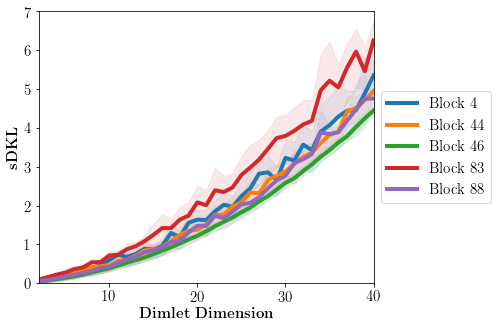

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

for idx, result in enumerate(results):
    v_sdkl = result['v_sdkl'][:]
    n_max_units = result['units'].shape[2]
    dims = 2 + np.arange(n_max_units - 1)
    sdkl_mean = np.mean(v_sdkl, axis=1)

    ax.fill_between(
        x=dims,
        y1=np.percentile(v_sdkl, q=25, axis=1),
        y2=np.percentile(v_sdkl, q=75, axis=1),
        color=f'C{idx}',
        alpha=0.1
    )
    ax.plot(
        dims,
        sdkl_mean,
        linewidth=4,
        color=f'C{idx}',
        label=f'Block {blocks[idx]}'
    )

    
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    prop={'size': 15}
)
ax.set_xlim([2, 40])
ax.set_ylim([0, 7])
ax.tick_params(labelsize=15)
ax.set_xlabel(r'\textbf{Dimlet Dimension}', fontsize=15)
ax.set_ylabel(r'\textbf{sDKL}', fontsize=15)
plt.savefig('exp5_sdkl_vs_dim.pdf', bbox_inches='tight')
plt.show()

In [6]:
p_s_vals = [
    np.mean(result['v_sdkl'][:][..., np.newaxis] > result['v_s_sdkl'][:], axis=-1)
    for result in results
]

In [7]:
p_r_vals = [
    np.mean(result['v_sdkl'][:][..., np.newaxis] > result['v_r_sdkl'][:], axis=-1)
    for result in results
]

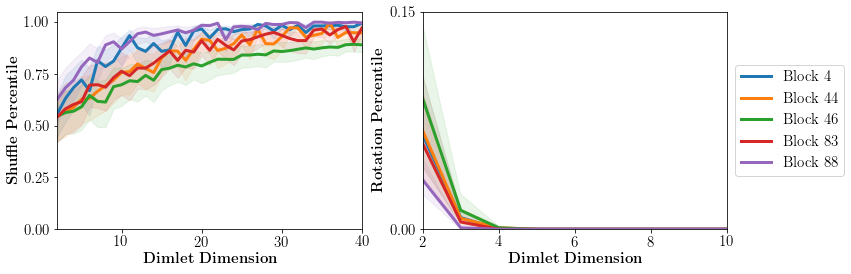

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, (result, p_s_val, p_r_val) in enumerate(zip(results, p_s_vals, p_r_vals)):
    n_max_units = result['units'].shape[2]
    dims = 2 + np.arange(n_max_units - 1)

    axes[0].plot(
        dims, np.median(p_s_val, axis=1),
        linewidth=3,
        color=f'C{idx}',
    )
    axes[0].fill_between(
        x=dims,
        y1=np.percentile(p_s_val, q=40, axis=1),
        y2=np.percentile(p_s_val, q=60, axis=1),
        color=f'C{idx}',
        alpha=0.1
    )
    axes[1].plot(
        dims, np.median(p_r_val, axis=1),
        linewidth=3,
        color=f'C{idx}',
        label=f'Block {blocks[idx]}'
    )
    axes[1].fill_between(
        x=dims,
        y1=np.percentile(p_r_val, q=40, axis=1),
        y2=np.percentile(p_r_val, q=60, axis=1),
        color=f'C{idx}',
        alpha=0.1
    )
    
axes[1].legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    prop={'size': 15}
)

for ax in axes:
    ax.set_xlim([2, 40])
    ax.set_xlabel(r'\textbf{Dimlet Dimension}', fontsize=15)
    ax.set_ylim([0, 1.05])
    ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
    ax.tick_params(labelsize=15)

axes[1].set_xlim([2, 10])
axes[1].set_ylim([0, 0.15])
axes[1].set_yticks([0, 0.15])

axes[0].set_ylabel(r'\textbf{Shuffle Percentile}', fontsize=15)
axes[1].set_ylabel(r'\textbf{Rotation Percentile}', fontsize=15)
plt.savefig('exp5_percentile_vs_dim.pdf', bbox_inches='tight')
plt.show()

# Comparison of values

In [12]:
def plot_kde_comparison(result, lim=[1e-3, 1e1]):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    v_sdkl = result['v_sdkl'][:]
    v_s_sdkl = np.median(result['v_s_sdkl'], axis=-1)
    v_r_sdkl = np.median(result['v_r_sdkl'], axis=-1)
    plot_dims = np.arange(0, result['units'].shape[2] + 1, 10)

    for idx, dim_idx in enumerate(plot_dims):
        color = plt.get_cmap('plasma')(int(idx / (plot_dims.size - 1) * 255))

        sns.kdeplot(
            x=v_sdkl[idx],
            y=v_s_sdkl[idx],
            fill=True,
            levels=5,
            log_scale=True,
            alpha=0.5,
            color=color,
            ax=axes[0]
        )
        sns.kdeplot(
            x=v_sdkl[idx],
            y=v_r_sdkl[idx],
            fill=True,
            levels=5,
            log_scale=True,
            alpha=0.5,
            color=color,
            ax=axes[1]
        )

    # Colorbars
    [[x0, y0], [x1, y1]] = axes[1].get_position().get_points()
    cax1 = fig.add_axes([x1 + 0.05 * (x1 - x0), y0, 0.05 * (x1 - x0), (y1 - y0)])
    cb1 = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=2, vmax=plot_dims.max()),
            cmap="plasma"
        ),
        cax=cax1)
    cb1.ax.tick_params(labelsize=18)

    # Labels
    axes[0].set_ylabel(r'\textbf{Median sDKL (Shuffle Null Model)}', fontsize=20)
    axes[1].set_ylabel(r'\textbf{Median sDKL (Rotation Null Model)}', fontsize=20)
    cb1.ax.set_ylabel(r'\textbf{Dimension}', labelpad=23, fontsize=18, rotation=270)

    for ax in axes:
        ax.tick_params(labelsize=15)
        ax.set_xlabel(r'\textbf{Observed sDKL}', fontsize=20)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot(ax.get_xlim(), ax.get_ylim(), color='k')

    return fig, axes

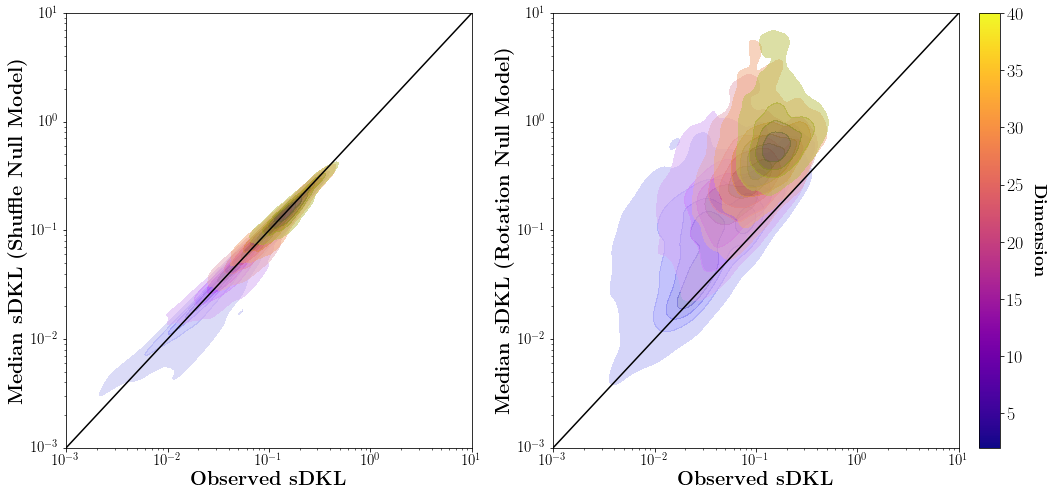

In [13]:
fig, axes = plot_kde_comparison(results[2])
plt.savefig('exp5_b46_kde_plot.pdf', bbox_inches='tight')